#**영화 리뷰 감성분류 경진대회 EDA**

#### 주어진 긍정 및 부정 리뷰 데이터를 이용하여 test 데이터의 긍/부정 라벨을 분류한다.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install konlpy
!pip install collections
!pip install wordcloud
!pip install sys

     |████████████████████████████████| 19.4 MB 536 kB/s 
     |████████████████████████████████| 448 kB 68.6 MB/s 
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

data=pd.read_csv('drive/MyDrive/Colab Notebooks/dataset/train.csv', encoding='utf-8')
data

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


### 결측치 확인

In [140]:
def check_missing(dataframe):
  missing_col=[]
  counted_missing_col=0
  for i,col in enumerate(dataframe.columns):
    missing_values=sum(dataframe[col].isna())
    is_missing=True if missing_values>=1 else False
    if is_missing:
      counted_missing_col+=1
      print(f'결측치가 있는 컬럼은: {col}입니다')
      print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
      missing_col.append([col, dataframe[col].dtype])
  if counted_missing_col==0:
    print('결측치가 존재하지 않습니다')
  return missing_col

missing_col=check_missing(data)

결측치가 존재하지 않습니다


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [142]:
val_count=data['label'].value_counts()
val_count

0    2564
1    2436
Name: label, dtype: int64

In [143]:
print('라벨 0인 리뷰개수:',val_count[0])
print('라벨 1인 리뷰개수:',val_count[1])

라벨 0인 리뷰개수: 2564
라벨 1인 리뷰개수: 2436


In [144]:
plt.style.use("ggplot")

In [145]:
# 히스토그램으로 데이터 분포 살피기

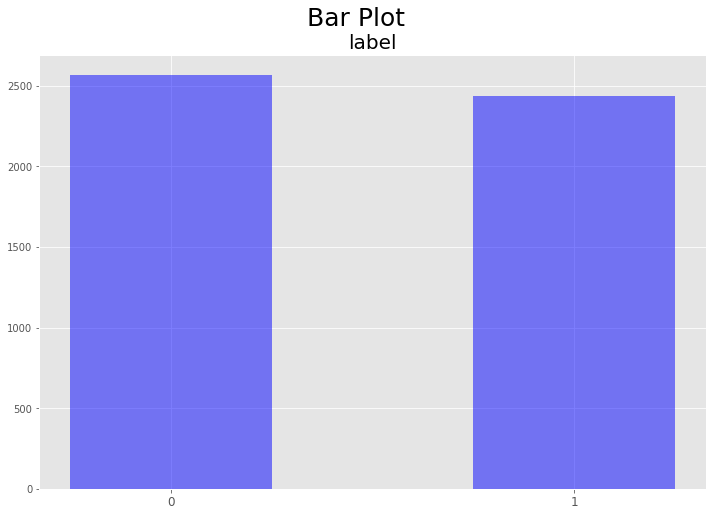

In [146]:
feature=data['label']

plt.figure(figsize=(10,7.5))# 그래프 이미지 크기 설정
plt.suptitle("Bar Plot", fontsize=25) # 모든 서브 플롯의 메인제목과 폰트 크기 설정

plt.title("label", fontsize=20) # 제목과 폰트 크기 설정
temp=feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0,0.03,1,0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 리뷰 길이 확인

In [147]:
str_len_mean=np.mean(data['document'].str.len()) # 리뷰 길이의 평균 값 계산
print('리뷰의 평균 길이:',str_len_mean)

리뷰의 평균 길이: 27.1352


### 전체리뷰/긍정리뷰/부정리뷰 비교

In [148]:
# 데이터 필터링을 위한 마스크 설정
mask_pos=(data.label==1)
mask_neg=(data.label==0)

# 전체/긍정/부정 리뷰 집합을 설정한다.
df_train=data.document.copy() # 전체 train 데이터
df_pos=data.loc[mask_pos, :].document # 긍정 리뷰에만 해당하는 train 데이터
df_neg=data.loc[mask_neg, :].document # 부정 리뷰에만 해당하는 train 데이터

# 세 집합을 리스트로 묶어준다.
compare=[df_train, df_pos, df_neg]

In [149]:
df_pos.head() # 긍정 데이터 확인

1            히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...
2    괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~
5       내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작
7          마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.
8                   가슴 찡했던, 오래 기억에남을 영화!!
Name: document, dtype: object

In [150]:
df_neg.head() # 부정 데이터 확인

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

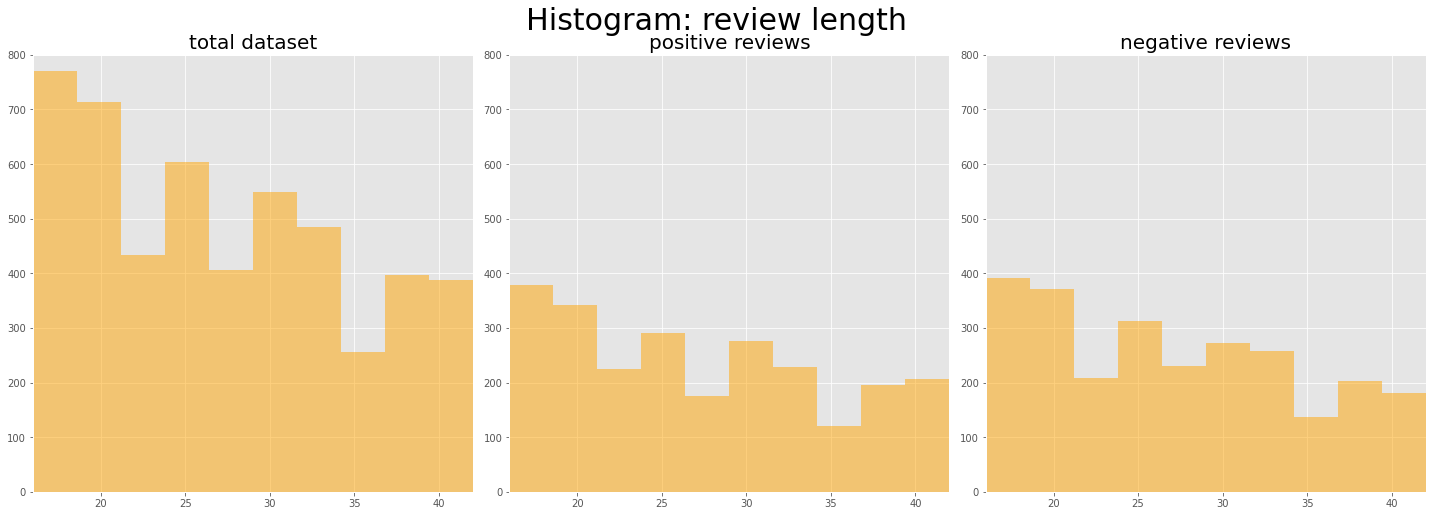

In [151]:
# 히스토그램을 사용해서 데이터 분포 살펴보기 
plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: review length", fontsize=30)
name=['total dataset','positive reviews','negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
  document=compare[i]
  string_len=[len(x) for x in document]
  plt.subplot(1,3,i+1) # 행 개수/열 개수/해당 그래프 표시 순서
  plt.title(name[i], fontsize=20)
  plt.axis([16,42,0,800]) # x축 시작,끝/ y축 시작,끝
  plt.hist(string_len, alpha=0.5, color='orange') # 히스토그램 생성, alpha: 그래프의 투명도 조절

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#### 문자열 길이는 16~42 사이에 분포하며 대체적으로 길이가 짧아질 수록 빈도수가 더 높은 것을 확인 할 수 있다.

#### 띄어쓰기를 기준으로 각 리뷰 당 포함하는 어절(word) 수를 살펴보자

In [152]:
word_split=data['document'].str.split() # 공백을 기준으로 문자열 분리
word_split[:5] # 상위 3개 값 확인

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

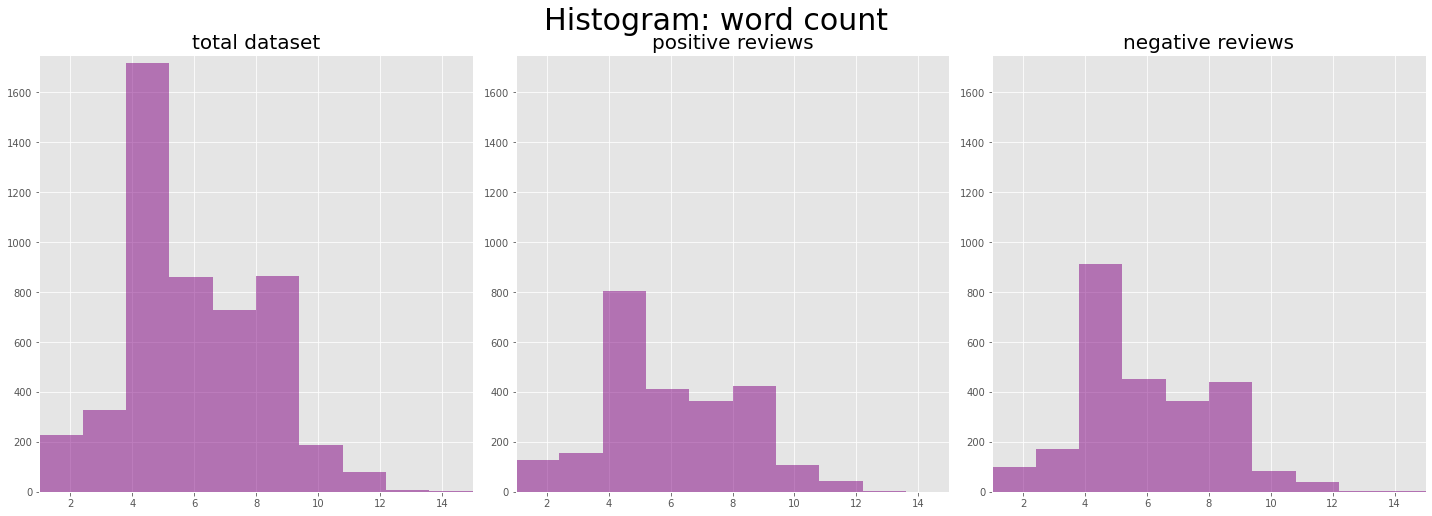

In [153]:
# 히스토그램을 사용하여 데이터의 분포를 살피기.
plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: word count", fontsize=30)
name=['total dataset','positive reviews','negative reviews'] # 제목으로 사용할 문자열

for i in range(len(compare)):
  document=compare[i]
  split=document.str.split()
  split_len=[len(x) for x in split]
  plt.subplot(1,3,i+1) # 행 개수/열 개수/해당 그래프 표시 순서
  plt.title(name[i], fontsize=20)
  plt.axis([1,15,0,1750]) # x축 시작,끝/ y축 시작,끝
  plt.hist(split_len, alpha=0.5, color='purple')

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#### 4~6개의 어절로 이루어진 리뷰가 가장 많은 것으로 확인된다.

### Word Cloud

#### 워드 클라우드(word cloud)란?
#### 태그 클라우드와 동의어인 워드 클라우드는 문서의 키워드 등을 직관적으로 파악할 수 있도록 하는 시각화 기법

#### 기본 함수 정의

In [213]:
def df2str(df):
  # 전체 리뷰들을 하나의 문자열로 만듦
  s=[s for s in df]
  document=''
  for i in range(len(s)):
    document+=s[i]
  return document

def get_noun(text):
  # okt tagger를 이용해 명사 추출
  okt=Okt()
  noun=okt.nouns(text)
  for i,v in enumerate(noun):
    if len(v)<2:
      noun.pop(i)
  count=Counter(noun)
  noun_list=count.most_common(100)

  return noun_list

def visualize(noun_list, title):
  # 워드클라우드 이미지 생성
  wc=WordCloud(
      font_path='drive/MyDrive/Colab Notebooks/font/NanumBarunGothic.ttf', # 폰트 설정
      background_color='white', # 배경색깔 정하기
      colormap="Dark2", # 폰트 색깔 정하기
      width=800,
      height=800
  ).generate_from_frequencies((dict(noun_list)))

  plt.figure(figsize=(10,10)) # 이미지 사이즈 지정
  plt.suptitle("Word Cloud", fontsize=30)
  plt.title(title, fontsize=20)
  plt.imshow(wc, interpolation='lanczos') # 이미지의 부드럽기 정도
  plt.axis('off') # x y 축 숫자 제거
  plt.show() # 워드클라우드 이미지 확인


  return wc

#### 전체 train 데이터 워드 클라우드 생성

In [214]:
document=df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list=get_noun(document) # 명사 추출, 개수 셈
noun_list[:5] # 상위 5개 단어 확인

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_

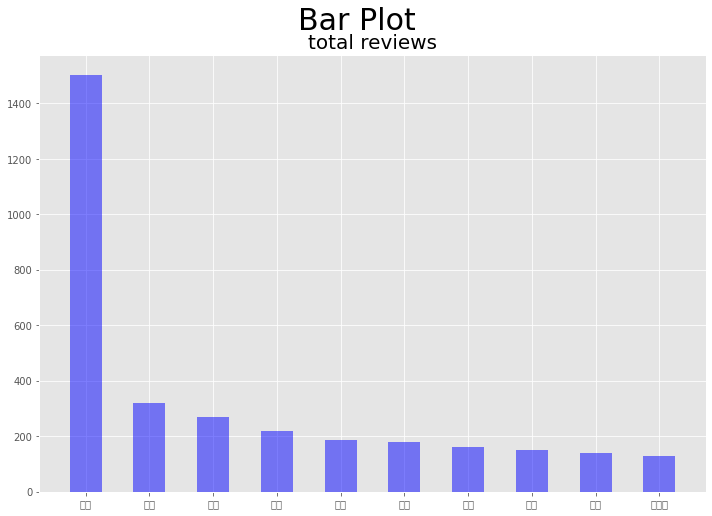

In [215]:
top_10=dict(noun_list[:10]) # 추출한 명사 중 상위 10개
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=30)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [216]:
print(top_10)

{'영화': 1501, '정말': 320, '진짜': 269, '최고': 220, '평점': 185, '연기': 181, '감동': 161, '재미': 152, '보고': 140, '스토리': 130}


####  



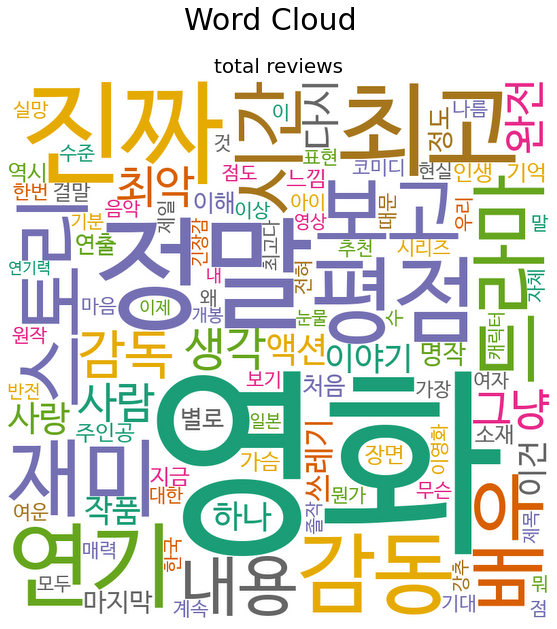

In [217]:
total_reviews=visualize(noun_list, 'total reviews') # 워드클라우드 시각화

### 긍정 리뷰 워드클라우드 생성

In [218]:
document_p=df2str(df_pos) # 긍정 리뷰 데이터프레임을 하나의 큰 문자열로 만들기
noun_list_p=get_noun(document_p) # 명사만을 추출하고 빈도수 계산
noun_list_p[:20] # 상위 20개 값 확인

[('영화', 757),
 ('정말', 216),
 ('최고', 214),
 ('진짜', 136),
 ('감동', 134),
 ('연기', 108),
 ('드라마', 89),
 ('보고', 88),
 ('사랑', 72),
 ('다시', 70),
 ('평점', 67),
 ('생각', 65),
 ('명작', 60),
 ('배우', 58),
 ('사람', 55),
 ('완전', 54),
 ('마지막', 52),
 ('가슴', 51),
 ('이야기', 50),
 ('재미', 48)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_

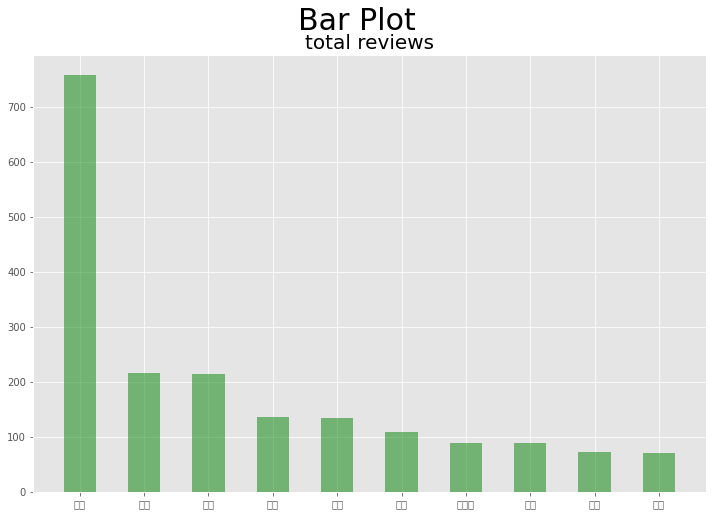

In [223]:
plt.rc('font', family='AppleGothic')
top_10=dict(noun_list_p[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle('Bar Plot', fontsize=30)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='green', alpha=0.5)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

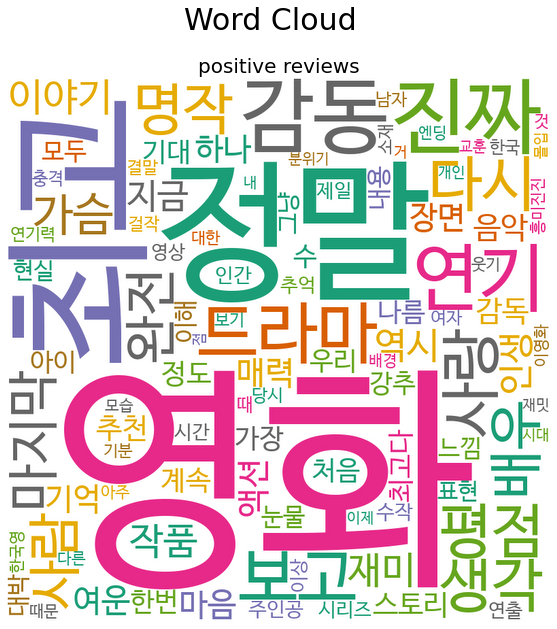

In [224]:
positive_reviews=visualize(noun_list_p,'positive reviews') # 워드클라우드 시각화

### 부정 리뷰

In [226]:
document_n=df2str(df_neg) # 부정 리뷰 데이터프레임을 하나의 큰 문자열로 만들기
noun_list_n=get_noun(document_n) # 명사만 추출, 빈도수 계산
noun_list_n[:20] # 상위 20개 값 확인

[('영화', 746),
 ('진짜', 132),
 ('평점', 118),
 ('재미', 104),
 ('정말', 104),
 ('스토리', 102),
 ('최악', 98),
 ('시간', 97),
 ('내용', 85),
 ('감독', 78),
 ('그냥', 75),
 ('연기', 72),
 ('쓰레기', 70),
 ('배우', 69),
 ('이건', 55),
 ('별로', 53),
 ('보고', 52),
 ('액션', 43),
 ('하나', 41),
 ('사람', 41)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_

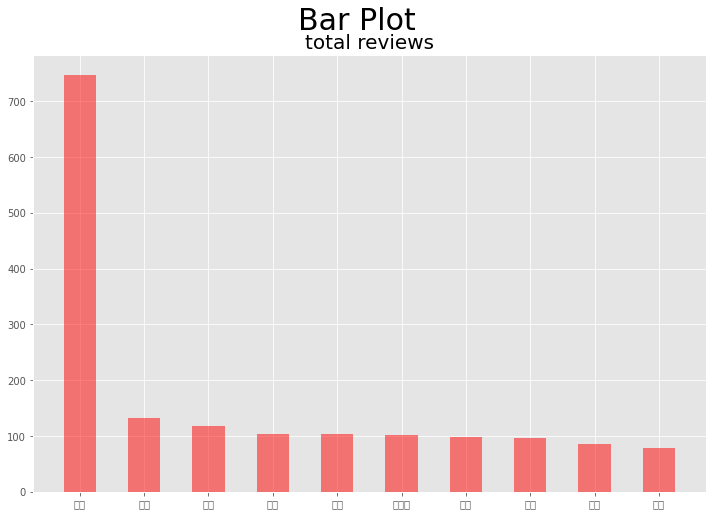

In [227]:
plt.rc('font', family='AppleGothic')
top_10=dict(noun_list_n[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle('Bar Plot', fontsize=30)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='r', alpha=0.5)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

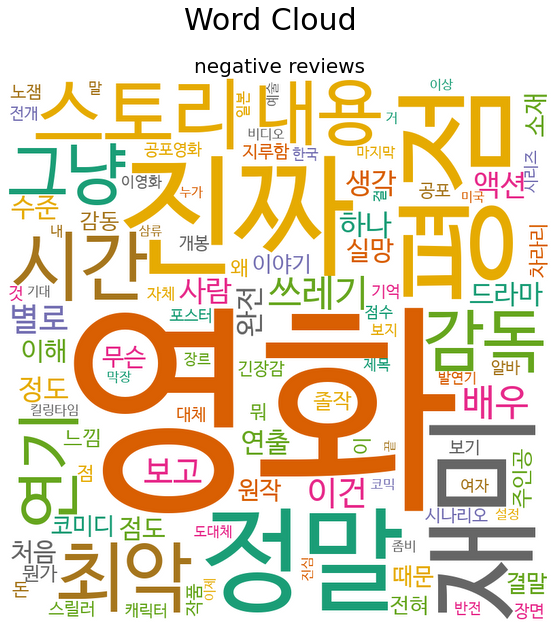

In [228]:
negative_reviews=visualize(noun_list_n,'negative reviews') # 워드클라우드 시각화

### 중복 단어 제거하기


In [229]:
print('부정리뷰 Top10:',noun_list_n[:10])
print('긍정리뷰 Top10:',noun_list_p[:10])

부정리뷰 Top10: [('영화', 746), ('진짜', 132), ('평점', 118), ('재미', 104), ('정말', 104), ('스토리', 102), ('최악', 98), ('시간', 97), ('내용', 85), ('감독', 78)]
긍정리뷰 Top10: [('영화', 757), ('정말', 216), ('최고', 214), ('진짜', 136), ('감동', 134), ('연기', 108), ('드라마', 89), ('보고', 88), ('사랑', 72), ('다시', 70)]


In [231]:
neg=list(dict(noun_list_n).keys()) # key(명사)만을 이용해 리스트 생성
pos=list(dict(noun_list_p).keys())

drop_words=[x for x in neg if x in pos] # 부정리뷰에 포함된 명사가 긍정리뷰에도 등장할 경우 drop_words에 저장
print('공통으로 등장하는 단어들 Top10\n', drop_words[:10])

공통으로 등장하는 단어들 Top10
 ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


In [234]:
noun_list_n_filter=[x for x in noun_list_n if x[0] not in drop_words] # drop_words 리스트에 포함되지 않은 부정리뷰 명사를 저장
noun_list_p_filter=[x for x in noun_list_p if x[0] not in drop_words] # drop_words 리스트에 포함되지 않은 긍정리뷰 명사를 저장

In [235]:
print('정제된 부정 리뷰 상위 단어 Top10\n', noun_list_n_filter[:10])

정제된 부정 리뷰 상위 단어 Top10
 [('최악', 98), ('쓰레기', 70), ('이건', 55), ('별로', 53), ('실망', 36), ('수준', 36), ('점도', 34), ('원작', 31), ('무슨', 31), ('코미디', 29)]


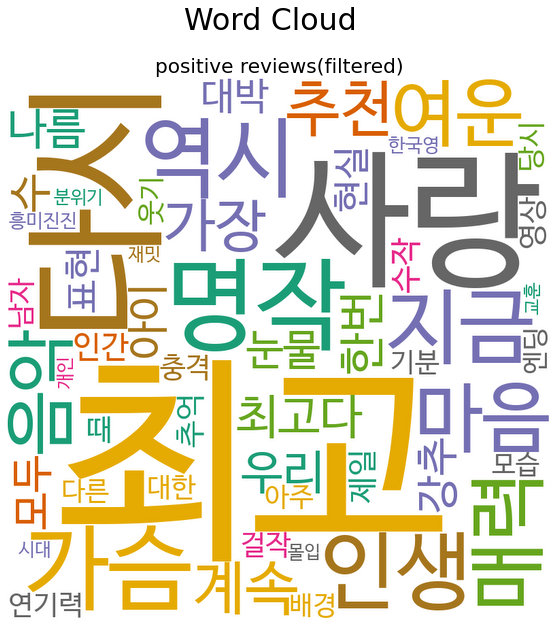

In [236]:
positive_reviews_filtered=visualize(noun_list_p_filter,'positive reviews(filtered)') # 워드클라우드 시각화

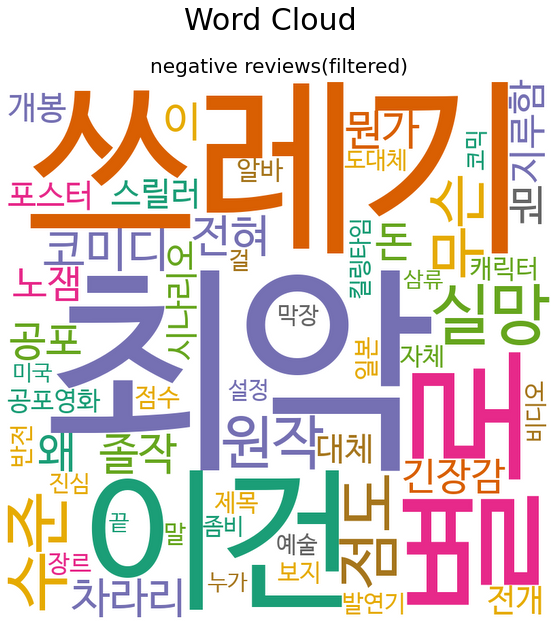

In [237]:
negative_reviews_filtered=visualize(noun_list_n_filter, 'negative reviews(filtered)') # 워드클라우드 시각화